In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from gpt.wien_filter import WienFilter
from gpt.lattice import Lattice
from gpt.element import Screen

from distgen import Generator
from distgen import PHYSICAL_CONSTANTS
from distgen.writers import write_gpt

qe = PHYSICAL_CONSTANTS.species('electron')['charge'].magnitude
MC2 = PHYSICAL_CONSTANTS.species('electron')['mc2'].magnitude
c = PHYSICAL_CONSTANTS['speed of light in vacuum'].magnitude

from matplotlib import pyplot as plt
import numpy as np
import os


In [3]:
#WF = WienFilter('WF1', 0.0001, 1, selection_energy=6.3e6)

In [4]:
#WF.place()

In [5]:
#WF.gpt_lines()

In [6]:
#WF.plot_floor()

In [7]:
lat = Lattice('SR')
lat.add(WienFilter('WF1', 0.02, 1.1267, selection_energy=6.3e6), ds=0.175)
lat.add(Screen('scr1'), ds=1.5, ref_element='beg')

<Axes: xlabel='z (m)', ylabel='x (m)'>

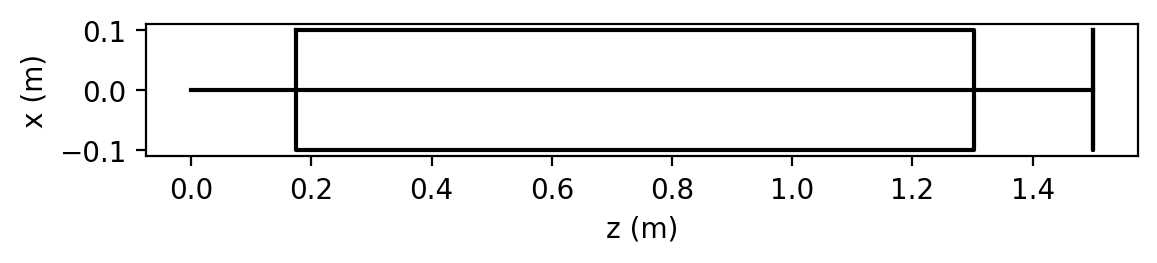

In [8]:
lat.plot_floor()

In [9]:
gpt_lines = lat.write_gpt_lines()

not a bend
no source data
not a bend
no source data
0
not a bend
no source data


In [10]:
with open('gpt.wf.temp.in', 'w') as fid:
    for line in gpt_lines:
        fid.write(line)

In [11]:
from gpt import GPT
from pmd_beamphysics import single_particle

In [12]:
G = GPT('gpt.wf.temp.in', 
        initial_particles = single_particle(pz = lat['WF1'].selection_momentum),
        load_fields=True,
        parse_layout=False
       )

In [13]:
G.set_variables({'Ntout': 500, 'ZSTOP':1.75, 'tmax': 50e-9})
G.run()

In [14]:
print(G)


GPT object:
   Original input file: gpt.wf.temp.in
   Template location: /Users/colwyngulliford/GitHub/lume-gpt/examples/elements
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/w8/8n1md1352pzd3nqp0lhc5jy00000gn/T/tmpw5meskb4
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.10357308387756348 (sec)


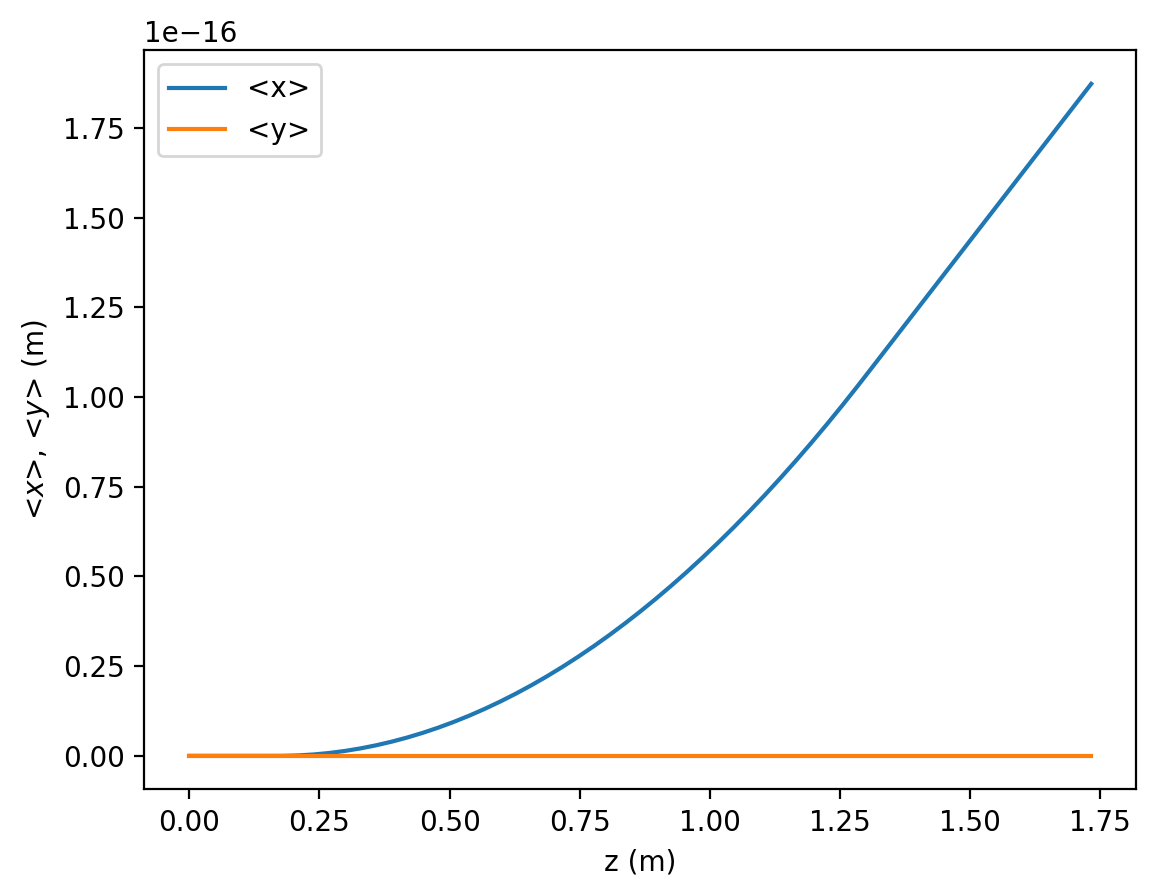

In [15]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_x'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_y'))
plt.xlabel('z (m)')
plt.ylabel(r'<$x$>, <$y$> (m)')
plt.legend([r'<x>', r'<y>'])

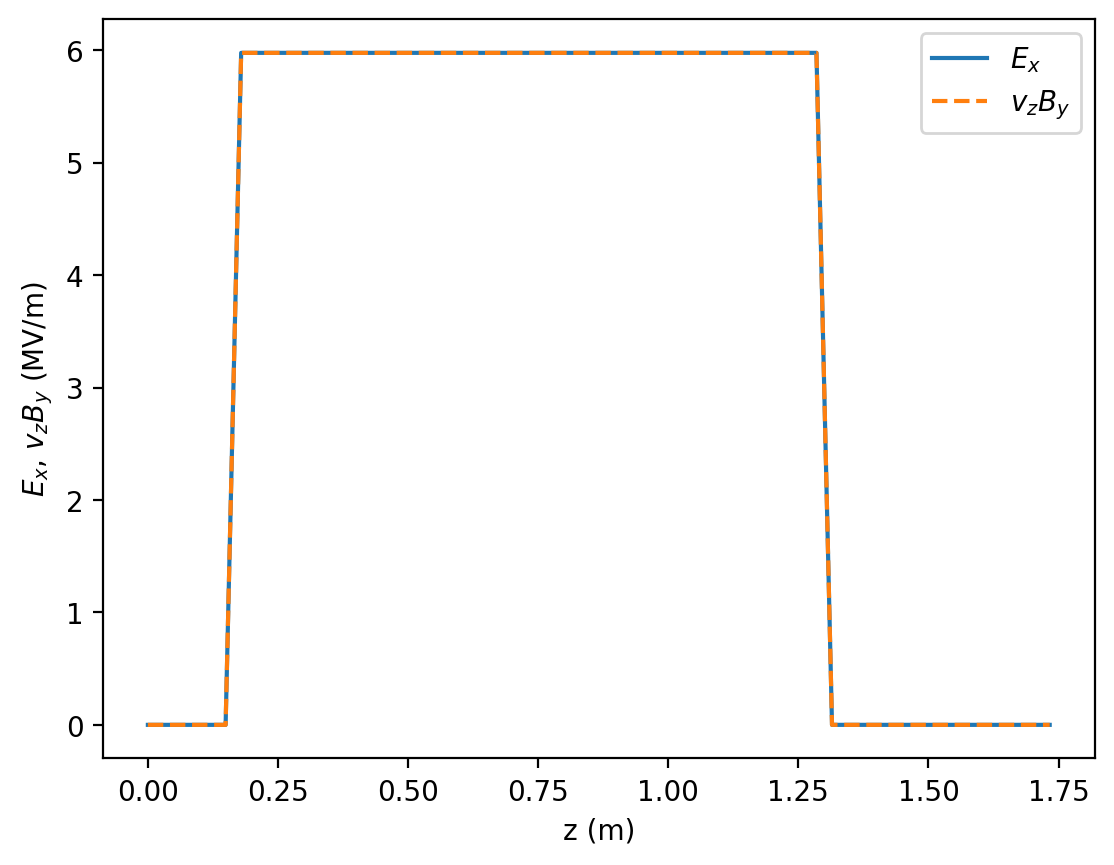

In [16]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_Ex')/1e6)
plt.plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_By')/1e6, '--')
plt.xlabel('z (m)') 
plt.ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

plt.legend([r'$E_x$', '$v_zB_y$'])

In [17]:
n_particle = 10_000

pz = lat['WF1'].selection_momentum

betax = 26.8694623292272
alphax = 5.054611659101098
betay = 3.953137534735184
alphay = 0.5054664771205715
emitx = 5.703115949842167E-08 
emity = 5.702851646473836E-08


YAML=f"""
n_particle: {n_particle}
output:
  type: null
random:
  type: hammersley
species: electron
spin_polarization: 0.85
spin_orientation:
  theta_x: -85 deg
  theta_y:  0 deg
  theta_z:  0 deg
start:
  tstart:
    units: second
    value: 0
  type: time
total_charge: 0.28 pC
#  units: coulomb
#  value: {n_particle*qe}
x_dist: 
  type: gaussian
  sigma_x: 1 mm
y_dist: 
  type: gaussian
  sigma_y: 1 mm
z_dist: 
  type: gaussian
  sigma_z: 150 um
px_dist:
  type: gaussian
  sigma_px: 1 keV/c
py_dist:
  type: gaussian
  sigma_py: 1 keV/c
pz_dist:
  type: gaussian
  avg_pz: {pz} eV/c
  sigma_pz: 20 keV/c
transforms:
  twiss_x:
    type: 'set_twiss x'
    beta: {betax} m
    alpha: {alphax} dimensionless
    emittance: {emitx} m
  twiss_y:
    type: 'set_twiss y'
    beta: {betay} m
    alpha: {alphay} dimensionless
    emittance: {emity} m

#  boost:
#    type: set_avg pz
#    avg_pz: {pz} eV/c
"""

D = Generator(YAML)
B = D.beam()

write_gpt(B, 'gpt_particles.gdf', asci2gdf_bin='$ASCI2GDF_BIN')

In [18]:
print(D)

<disgten.Generator with input: 
n_particle: 10000
output:
  type: null
px_dist:
  sigma_px:
    units: kiloelectron_volt / speed_of_light
    value: 1.0
  type: gaussian
py_dist:
  sigma_py:
    units: kiloelectron_volt / speed_of_light
    value: 1.0
  type: gaussian
pz_dist:
  avg_pz:
    units: electron_volt / speed_of_light
    value: 6279241.998290849
  sigma_pz:
    units: kiloelectron_volt / speed_of_light
    value: 20.0
  type: gaussian
random:
  type: hammersley
species: electron
spin_orientation:
  theta_x:
    units: degree
    value: -85
  theta_y:
    units: degree
    value: 0
  theta_z:
    units: degree
    value: 0
spin_polarization: 0.85
start:
  tstart:
    units: second
    value: 0.0
  type: time
total_charge:
  units: picocoulomb
  value: 0.28
transforms:
  twiss_x:
    alpha:
      units: dimensionless
      value: 5.054611659101098
    beta:
      units: meter
      value: 26.8694623292272
    emittance:
      units: meter
      value: 5.703115949842167e-08
   

In [19]:
G = GPT('gpt.wf.temp.in', 
        load_fields=True,
        spin_tracking=True,
        parse_layout=False)

In [20]:
G.set_variables({'Ntout': 500, 'ZSTOP':4.0, 'tmax': 50e-9, 'space_charge':1})

{'Ntout': True, 'ZSTOP': True, 'tmax': True, 'space_charge': True}

In [21]:
G.run()

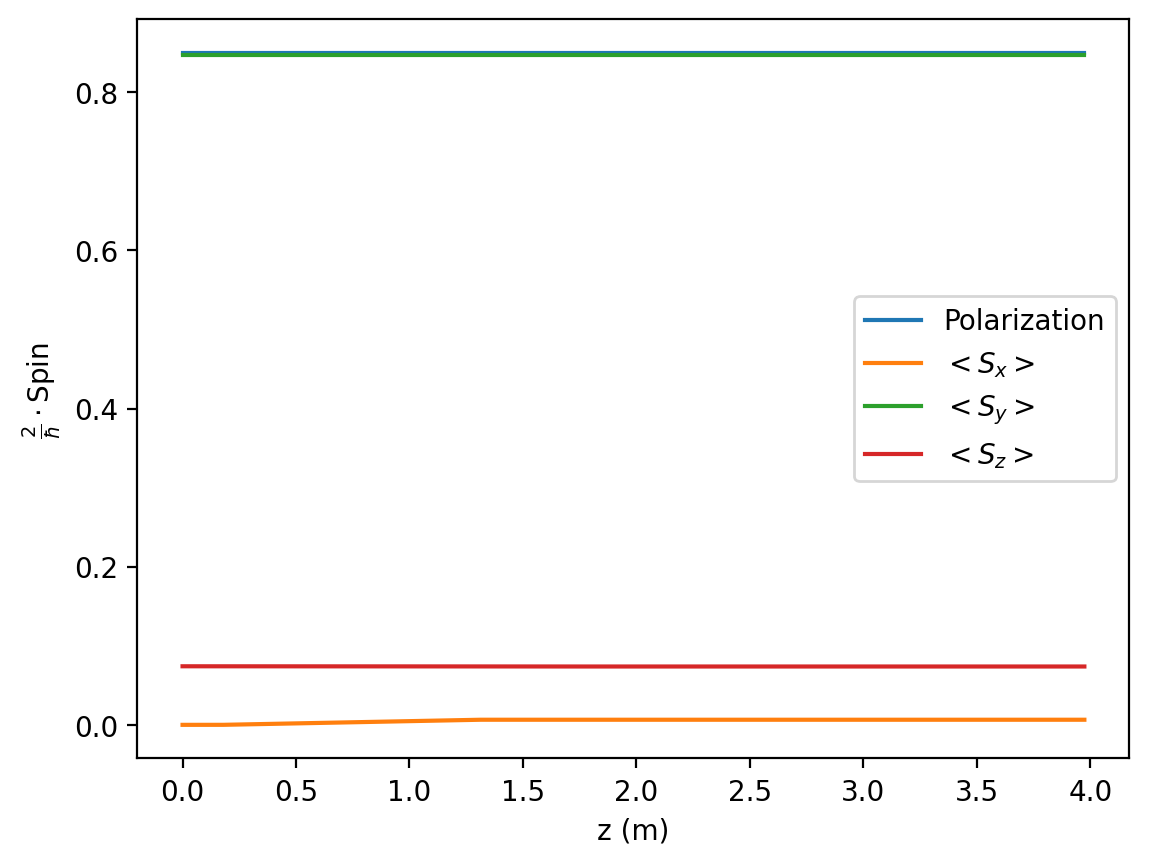

In [22]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('spin_polarization'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_sx'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_sy'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_sz'))


plt.xlabel('z (m)')
plt.ylabel(r'$\frac{2}{\hbar}\cdot$Spin ')

plt.legend(['Polarization', '$<S_x>$', '$<S_y>$', '$<S_z>$'])

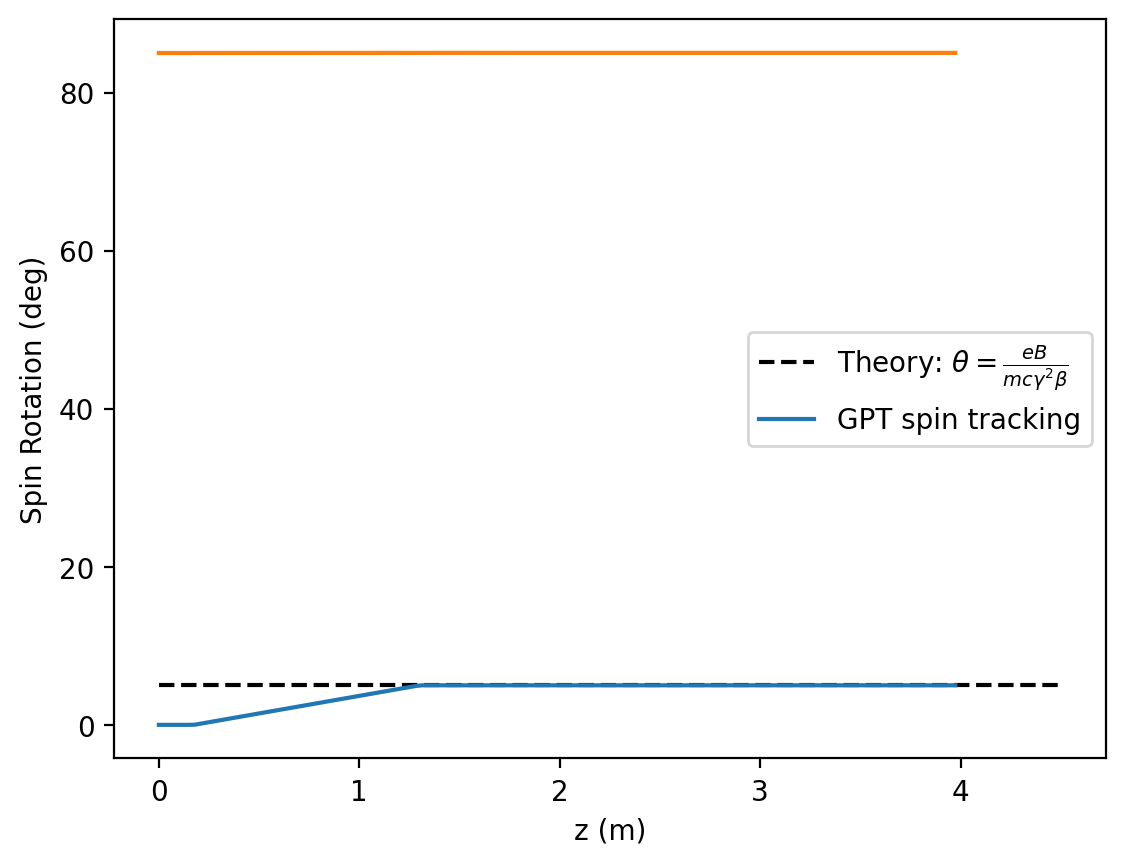

In [23]:
plt.plot([0, 4.5], [5, 5], '--k')
plt.plot(G.tout_stat('mean_z'), np.atan2(G.tout_stat('mean_sx'), G.tout_stat('mean_sz'))*180/np.pi)
plt.plot(G.tout_stat('mean_z'), np.atan2(G.tout_stat('mean_sy'), G.tout_stat('mean_sz'))*180/np.pi)

#plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_sz'))
#plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_sx'))

plt.xlabel('z (m)')
plt.ylabel('Spin Rotation (deg)')
plt.legend([r'Theory: $\theta = \frac{eB}{mc\gamma^2\beta}$', 'GPT spin tracking', ])

In [24]:
def get_rotation(z, B, E):

    gamma = E/MC2

    beta = np.sqrt(1-1/gamma**2)

    return c*B * z / MC2 / gamma**2 / beta

def Bmag(beta, alpha, beta0, alpha0):

    return 0.5 * ( (beta0/beta + beta/beta0) + beta*beta0*(alpha/beta - alpha0/beta0)**2 )

In [25]:
get_rotation(1.1267, 0.02, 6.3e6) * 180/np.pi

np.float64(4.999814166897575)

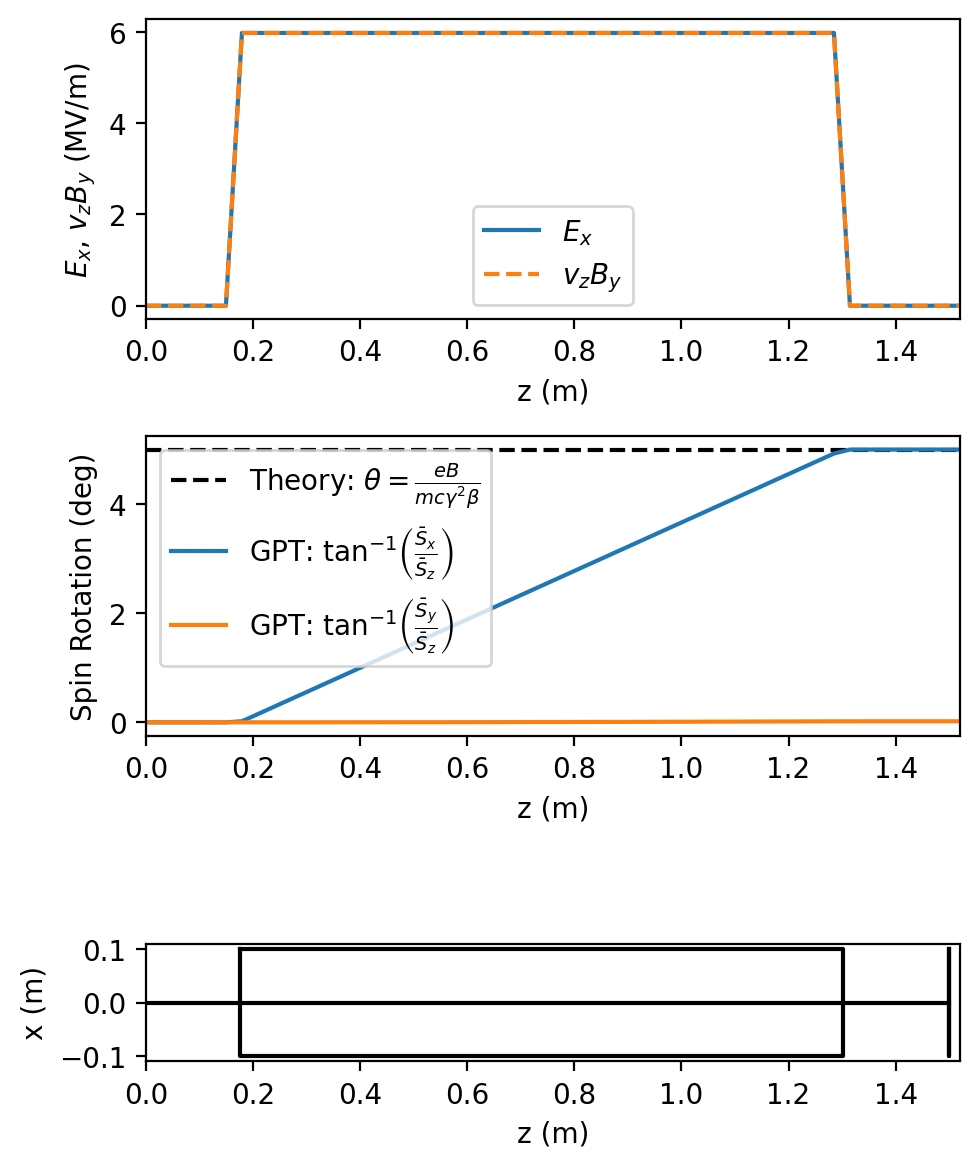

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(5, 6))

axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('mean_Ex')/1e6)
axs[0].plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_By')/1e6, '--')
axs[0].set_xlabel('z (m)') 
axs[0].set_ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

axs[0].legend([r'$E_x$', '$v_zB_y$'])

axs[1].plot([0, 4.5], [5, 5], '--k')

thetax = np.atan2(G.tout_stat('mean_sx'), G.tout_stat('mean_sz'))*180/np.pi
thetay = np.atan2(G.tout_stat('mean_sy'), G.tout_stat('mean_sz'))*180/np.pi           

axs[1].plot(G.tout_stat('mean_z'), thetax - thetax[0])
axs[1].plot(G.tout_stat('mean_z'), thetay - thetay[0])

axs[1].set_xlabel('z (m)')
axs[1].set_ylabel('Spin Rotation (deg)')
axs[1].legend([r'Theory: $\theta = \frac{eB}{mc\gamma^2\beta}$', 
               r'GPT: $\text{tan}^{-1}\left(\frac{\bar{S}_x}{\bar{S}_z}\right)$', 
               r'GPT: $\text{tan}^{-1}\left(\frac{\bar{S}_y}{\bar{S}_z}\right)$'])


lat.plot_floor(ax=axs[-1])

for ii in range(len(axs)):
    axs[ii].set_xlim([0, 1.52])

plt.tight_layout()

#plt.savefig('6MeV_Wien_Filter_example.pdf')

Text(0, 0.5, '$\\sigma_x$, $\\sigma_y$ (mm)')

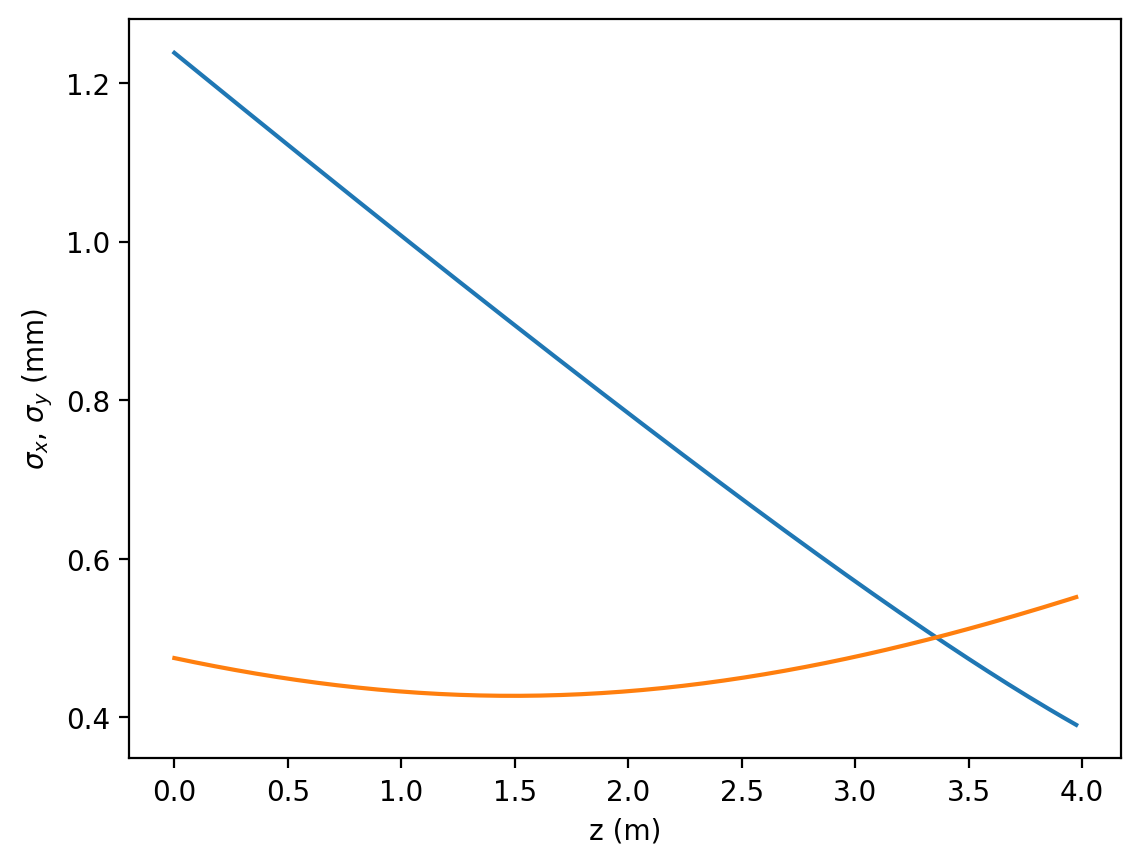

In [27]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('sigma_x')*1e3)
plt.plot(G.tout_stat('mean_z'), G.tout_stat('sigma_y')*1e3)
plt.xlabel('z (m)')
plt.ylabel(r'$\sigma_x$, $\sigma_y$ (mm)')

In [28]:
#os.remove('gpt_particles.gdf')
#os.remove('gpt.wf.temp.in')

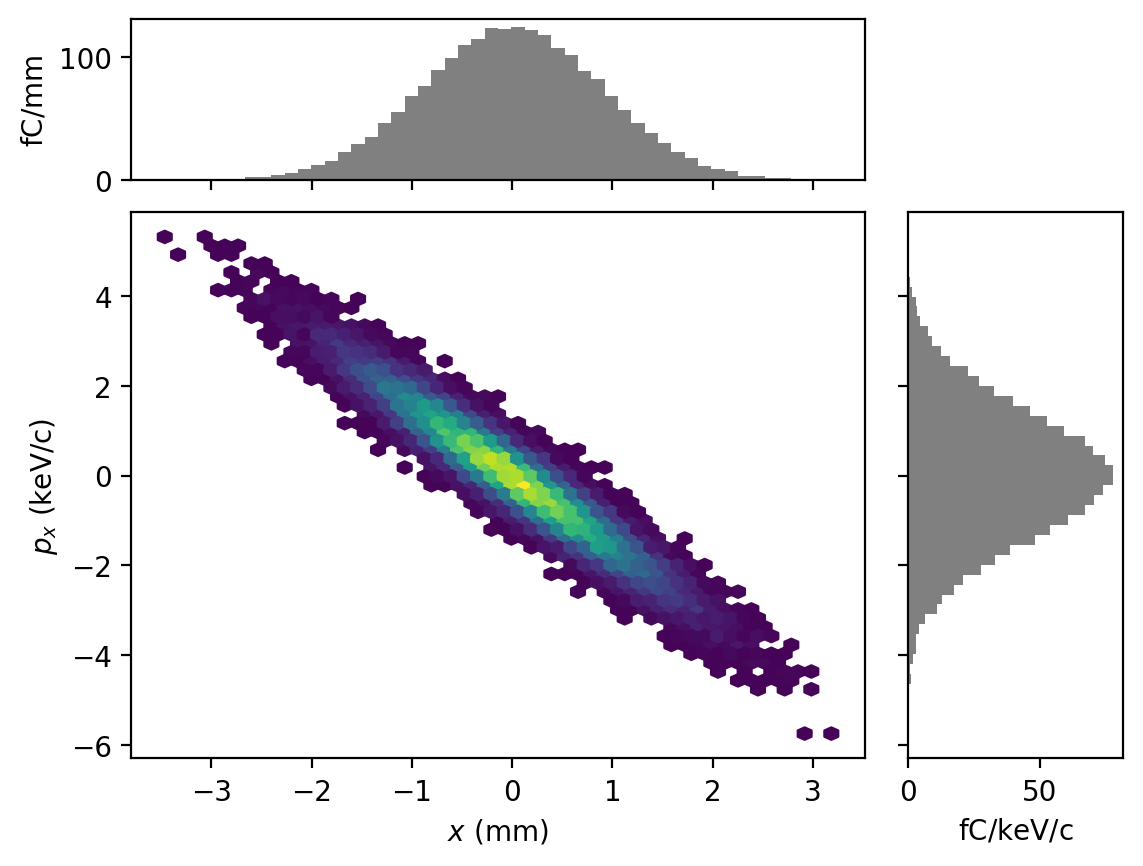

In [29]:
G.screen[-1].plot('x', 'px')

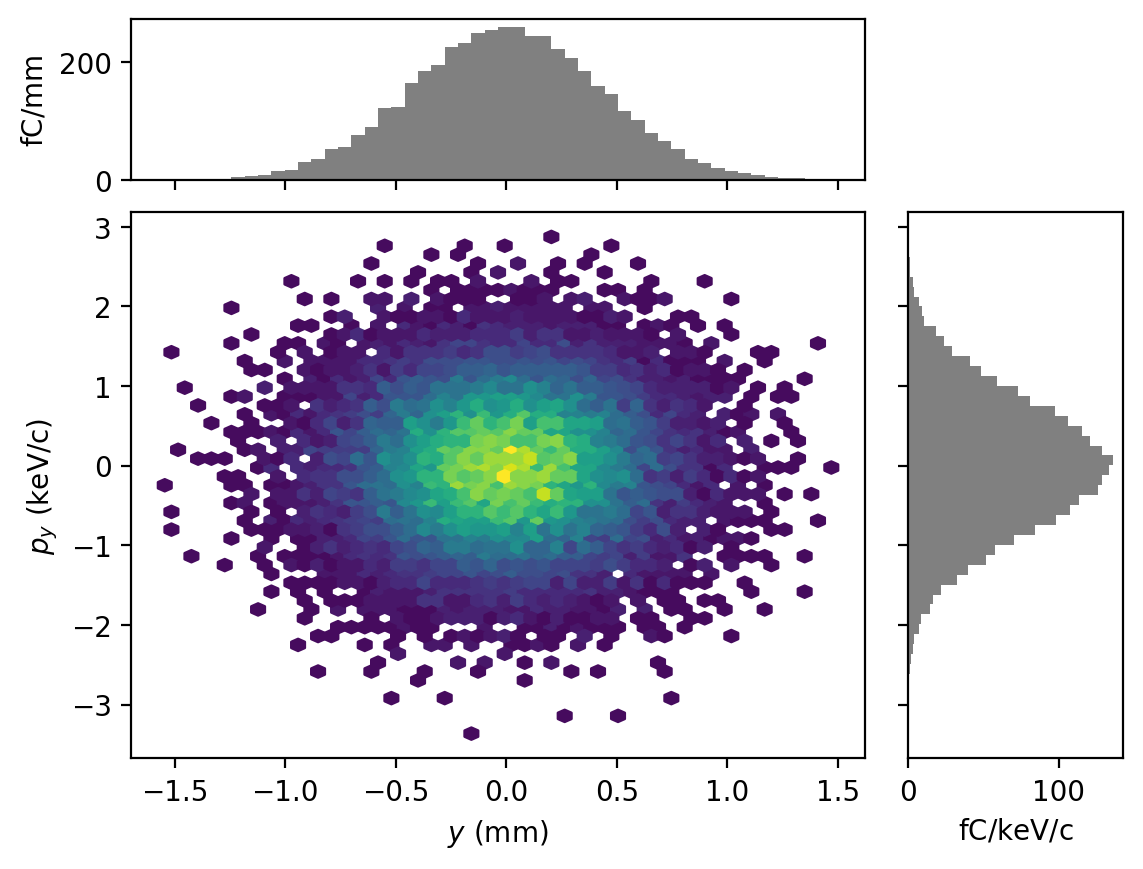

In [30]:
G.screen[-1].plot('y', 'py')

In [31]:
def set_wien_filter(theta, L, E0, G):

    gamma = E0/MC2
    beta = np.sqrt(1 - 1/gamma**2)

    B = theta * MC2*gamma**2 * beta / c / L
    E = c * beta * B

    res = G.set_variables({'WF1_E0':E, 'WF1_B0': B});
    print(B, E, res)

    return G

In [32]:
set_wien_filter(5 * np.pi/180, 1.2, 6.3e6, G)

0.018779031286462237 5611262.163141092 {'WF1_E0': True, 'WF1_B0': True}


In [33]:
def perform_scan(thetas, E0, L, gpt_file='gpt.wf.temp.in'):

    runs=[]
    
    for theta in thetas:

        G = GPT(gpt_file, 
                load_fields=True,
                spin_tracking=True,
                parse_layout=False)

        G.set_variables({'Ntout': 500, 'ZSTOP':2.0, 'tmax': 50e-9, 'space_charge':1})
        
        Gth = set_wien_filter(theta * np.pi/180, L, E0, G)
        Gth.run()
        runs.append(Gth)

    return runs



In [34]:
ths = np.linspace(-5, 5, 51)

runs = perform_scan(ths, 6.3e6, 1.2)

-0.018779031286462237 -5611262.163141092 {'WF1_E0': True, 'WF1_B0': True}
-0.018027870035003744 -5386811.676615448 {'WF1_E0': True, 'WF1_B0': True}
-0.01727670878354525 -5162361.190089802 {'WF1_E0': True, 'WF1_B0': True}
-0.01652554753208677 -4937910.703564161 {'WF1_E0': True, 'WF1_B0': True}
-0.015774386280628275 -4713460.217038516 {'WF1_E0': True, 'WF1_B0': True}
-0.015023225029169788 -4489009.730512873 {'WF1_E0': True, 'WF1_B0': True}
-0.014272063777711296 -4264559.243987229 {'WF1_E0': True, 'WF1_B0': True}
-0.013520902526252807 -4040108.757461585 {'WF1_E0': True, 'WF1_B0': True}
-0.01276974127479432 -3815658.2709359424 {'WF1_E0': True, 'WF1_B0': True}
-0.01201858002333583 -3591207.784410299 {'WF1_E0': True, 'WF1_B0': True}
-0.011267418771877341 -3366757.2978846547 {'WF1_E0': True, 'WF1_B0': True}
-0.01051625752041885 -3142306.8113590106 {'WF1_E0': True, 'WF1_B0': True}
-0.009765096268960358 -2917856.3248333666 {'WF1_E0': True, 'WF1_B0': True}
-0.009013935017501872 -2693405.83830772

25


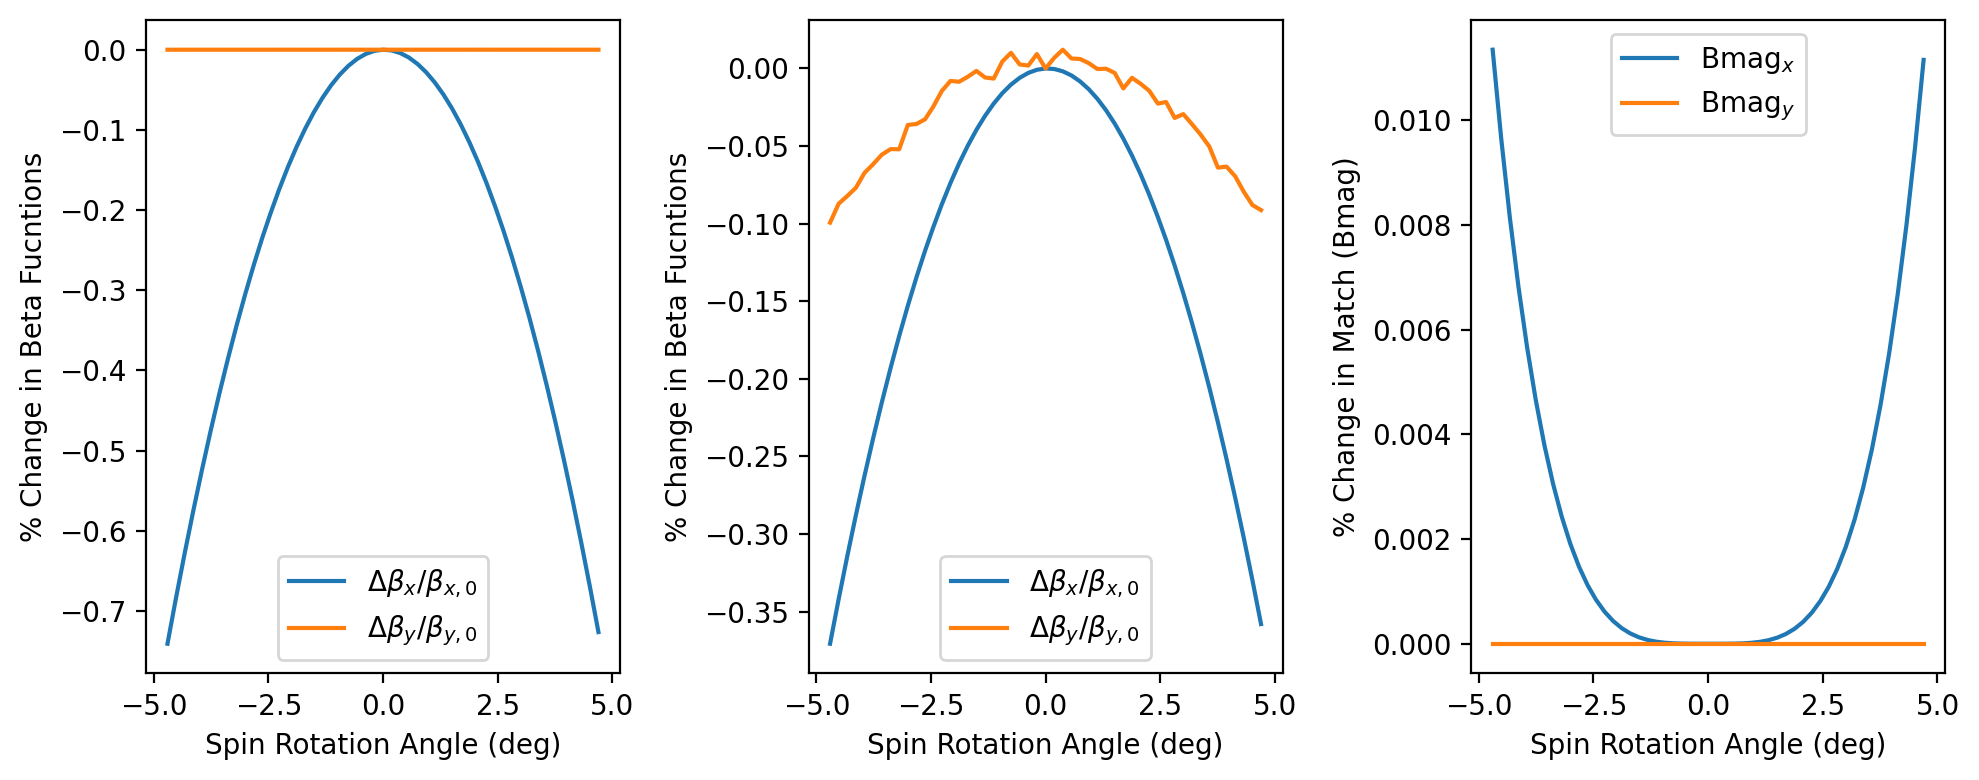

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

thetax = np.array([np.atan2(G.screen_stat('mean_sx')[-1], G.screen_stat('mean_sz')[-1])*180/np.pi for G in runs])

betax = np.array([G.screen[-1].twiss('x')['beta_x'] for G in runs])
betay = np.array([G.screen[-1].twiss('y')['beta_y'] for G in runs])

alphax = np.array([G.screen[-1].twiss('x')['alpha_x'] for G in runs])
alphay = np.array([G.screen[-1].twiss('y')['alpha_y'] for G in runs])

stdx = np.array([G.screen_stat('sigma_x')[-1] for G in runs])
stdy = np.array([G.screen_stat('sigma_y')[-1] for G in runs])

ic = int(len(stdx)/2) 

bmagx = Bmag(betax, alphax, betax[ic], alphax[ic])
bmagy = Bmag(betay, alphay, betay[ic], alphay[ic])

axs[0].plot(thetax, 100*(betax - betax[ic])/betax[ic])
axs[0].plot(thetax, 100*(betay - betay[ic])/betay[ic])
axs[0].set_xlabel('Spin Rotation Angle (deg)')
axs[0].set_ylabel(r'% Change in Beta Fucntions')
axs[0].legend([r'$\Delta\beta_x/\beta_{x,0}$', r'$\Delta\beta_y/\beta_{y,0}$'])

axs[1].plot(thetax, 100*(alphax - alphax[ic])/alphax[ic])
axs[1].plot(thetax, 100*(alphay - alphay[ic])/alphay[ic])
axs[1].set_xlabel('Spin Rotation Angle (deg)')
axs[1].set_ylabel(r'% Change in Beta Fucntions')
axs[1].legend([r'$\Delta\beta_x/\beta_{x,0}$', r'$\Delta\beta_y/\beta_{y,0}$'])

axs[2].plot(thetax, 100*(bmagx-1))
axs[2].plot(thetax, 100*(bmagy-1))
axs[2].set_xlabel('Spin Rotation Angle (deg)')
axs[2].set_ylabel(r'% Change in Match (Bmag)')
axs[2].legend([r'$\text{Bmag}_x$', r'$\text{Bmag}_y$'])

plt.tight_layout()

In [36]:
#G.screen[-1].twiss()

In [37]:
def get_fields(theta, E0, L):
    gamma = E0/MC2
    beta = np.sqrt(1 - 1/gamma**2)

    B = theta * MC2*gamma**2 * beta / c / L
    E = c * beta * B

    print(B , E)

In [38]:
get_fields(10*np.pi/180, 6.3e6, 1.5)

0.030046450058339575 8978019.461025747


In [39]:
get_fields(5*np.pi/180, 6.3e6, 1.5)

0.015023225029169788 4489009.730512873


In [40]:
lat2 = Lattice('SR')
lat2.add(WienFilter('WF1', 0.030046450058339575, 1.5, selection_energy=6.3e6), ds=0.12)
lat2.add(Screen('scr1'), ds=1.75, ref_element='beg')

<Axes: xlabel='z (m)', ylabel='x (m)'>

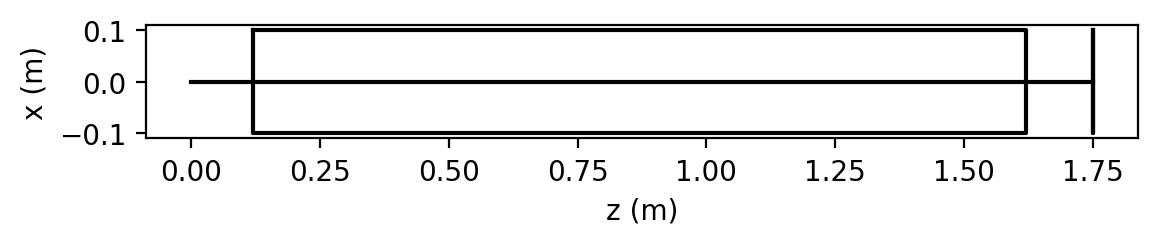

In [41]:
lat2.plot_floor()

In [42]:
gpt_lines2 = lat2.write_gpt_lines()
with open('gpt.wf.temp2.in', 'w') as fid:
    for line in gpt_lines2:
        fid.write(line)

not a bend
no source data
not a bend
no source data
0
not a bend
no source data


In [43]:
G = GPT('gpt.wf.temp2.in', 
        initial_particles = single_particle(pz = lat2['WF1'].selection_momentum),
        load_fields=True,
        parse_layout=False)

G.set_variables({'Ntout': 500, 'ZSTOP':1.75, 'tmax': 50e-9})
G.run()

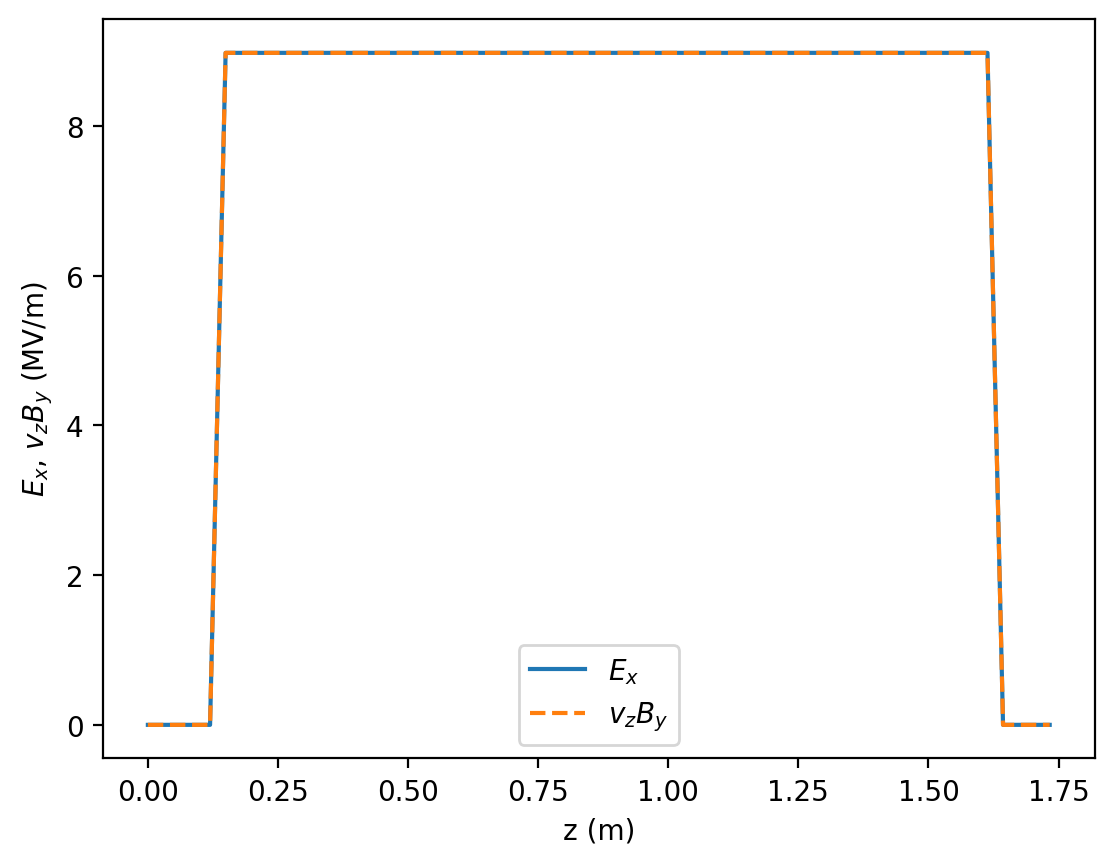

In [44]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_Ex')/1e6)
plt.plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_By')/1e6, '--')
plt.xlabel('z (m)') 
plt.ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

plt.legend([r'$E_x$', '$v_zB_y$'])

In [45]:
ths2 = np.linspace(0, 10, 51)

runs2 = perform_scan(ths2, 6.3e6, 1.5, gpt_file='gpt.wf.temp2.in')

0.0 0.0 {'WF1_E0': True, 'WF1_B0': True}
0.0006009290011667915 179560.38922051495 {'WF1_E0': True, 'WF1_B0': True}
0.001201858002333583 359120.7784410299 {'WF1_E0': True, 'WF1_B0': True}
0.0018027870035003746 538681.1676615448 {'WF1_E0': True, 'WF1_B0': True}
0.002403716004667166 718241.5568820598 {'WF1_E0': True, 'WF1_B0': True}
0.0030046450058339572 897801.9461025746 {'WF1_E0': True, 'WF1_B0': True}
0.0036055740070007492 1077362.3353230895 {'WF1_E0': True, 'WF1_B0': True}
0.00420650300816754 1256922.7245436043 {'WF1_E0': True, 'WF1_B0': True}
0.004807432009334332 1436483.1137641196 {'WF1_E0': True, 'WF1_B0': True}
0.005408361010501124 1616043.5029846344 {'WF1_E0': True, 'WF1_B0': True}
0.0060092900116679145 1795603.8922051492 {'WF1_E0': True, 'WF1_B0': True}
0.006610219012834707 1975164.2814256642 {'WF1_E0': True, 'WF1_B0': True}
0.0072111480140014984 2154724.670646179 {'WF1_E0': True, 'WF1_B0': True}
0.00781207701516829 2334285.0598666943 {'WF1_E0': True, 'WF1_B0': True}
0.008413006

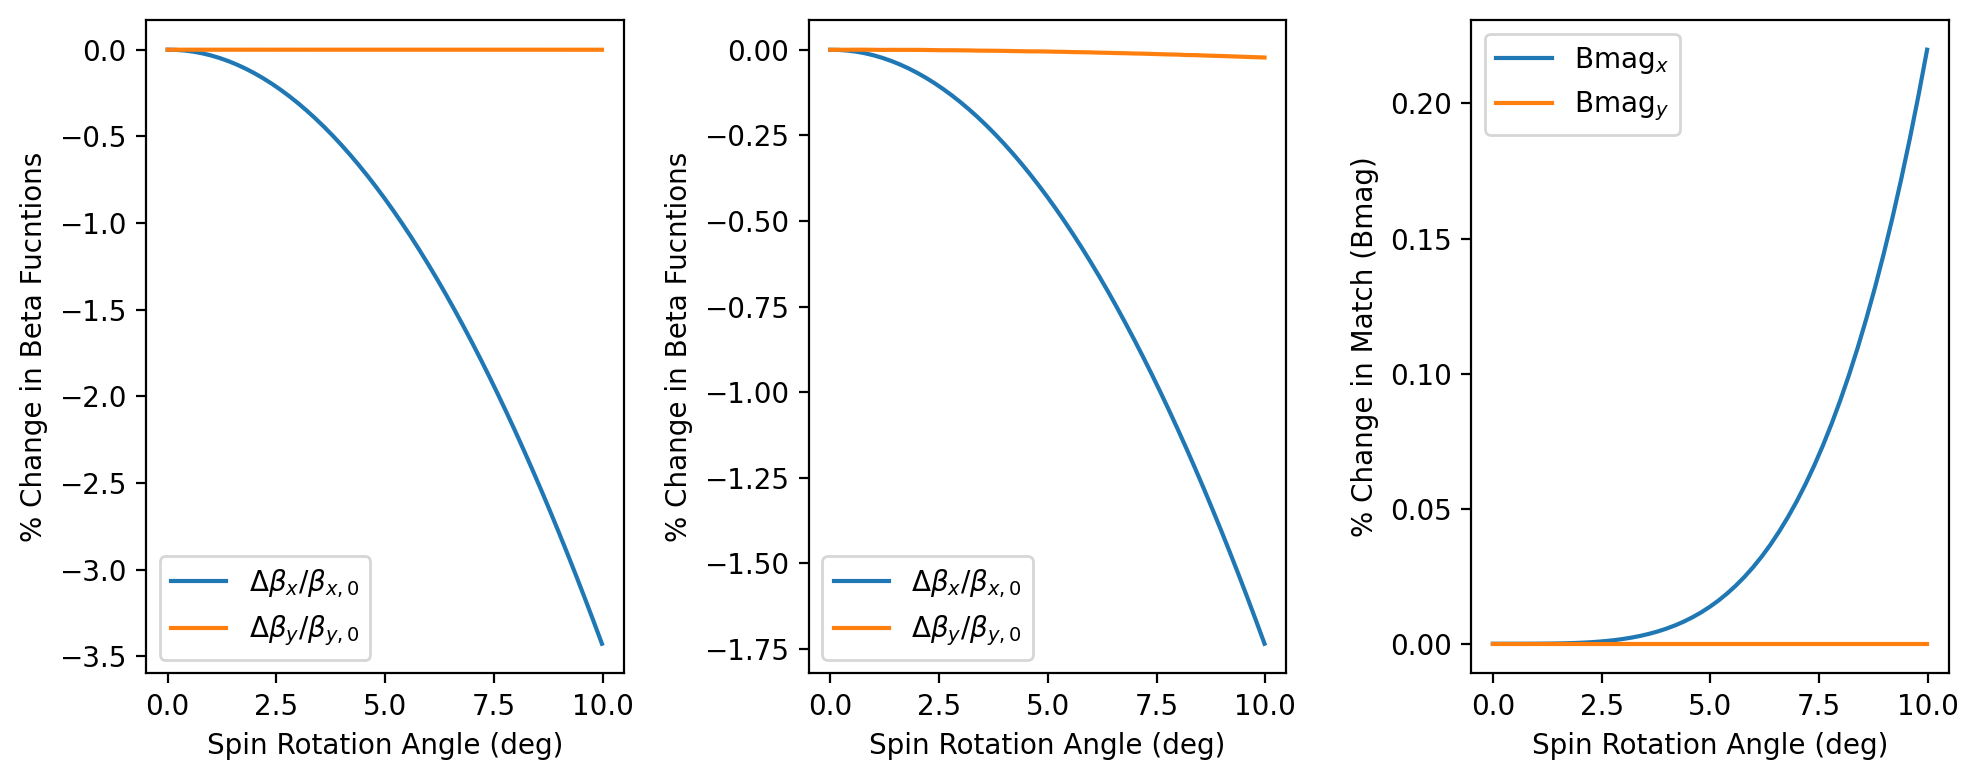

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))

thetax2 = np.array([np.atan2(G.screen_stat('mean_sx')[-1], G.screen_stat('mean_sz')[-1])*180/np.pi for G in runs2])

betax2 = np.array([G.screen[-1].twiss('x')['beta_x'] for G in runs2])
betay2 = np.array([G.screen[-1].twiss('y')['beta_y'] for G in runs2])

alphax2 = np.array([G.screen[-1].twiss('x')['alpha_x'] for G in runs2])
alphay2 = np.array([G.screen[-1].twiss('y')['alpha_y'] for G in runs2])

stdx2 = np.array([G.screen_stat('sigma_x')[-1] for G in runs2])
stdy2 = np.array([G.screen_stat('sigma_y')[-1] for G in runs2])

bmagx2 = Bmag(betax2, alphax2, betax2[0], alphax2[0])
bmagy2 = Bmag(betay2, alphay2, betay2[0], alphay2[0])


axs[0].plot(thetax2, 100*(betax2 - betax2[0])/betax2[0])
axs[0].plot(thetax2, 100*(betay2 - betay2[0])/betay2[0])
axs[0].set_xlabel('Spin Rotation Angle (deg)')
axs[0].set_ylabel(r'% Change in Beta Fucntions')
axs[0].legend([r'$\Delta\beta_x/\beta_{x,0}$', r'$\Delta\beta_y/\beta_{y,0}$'])

axs[1].plot(thetax2, 100*(alphax2 - alphax2[0])/alphax2[0])
axs[1].plot(thetax2, 100*(alphay2 - alphay2[0])/alphay2[0])
axs[1].set_xlabel('Spin Rotation Angle (deg)')
axs[1].set_ylabel(r'% Change in Beta Fucntions')
axs[1].legend([r'$\Delta\beta_x/\beta_{x,0}$', r'$\Delta\beta_y/\beta_{y,0}$'])

axs[2].plot(thetax2, 100*(bmagx2-1))
axs[2].plot(thetax2, 100*(bmagy2-1))
#axs[2].plot(thetax2, 100*(alphay2 - alphay2[0])/alphay2[0])
axs[2].set_xlabel('Spin Rotation Angle (deg)')
axs[2].set_ylabel(r'% Change in Match (Bmag)')
axs[2].legend([r'$\text{Bmag}_x$', r'$\text{Bmag}_y$'])

plt.tight_layout()

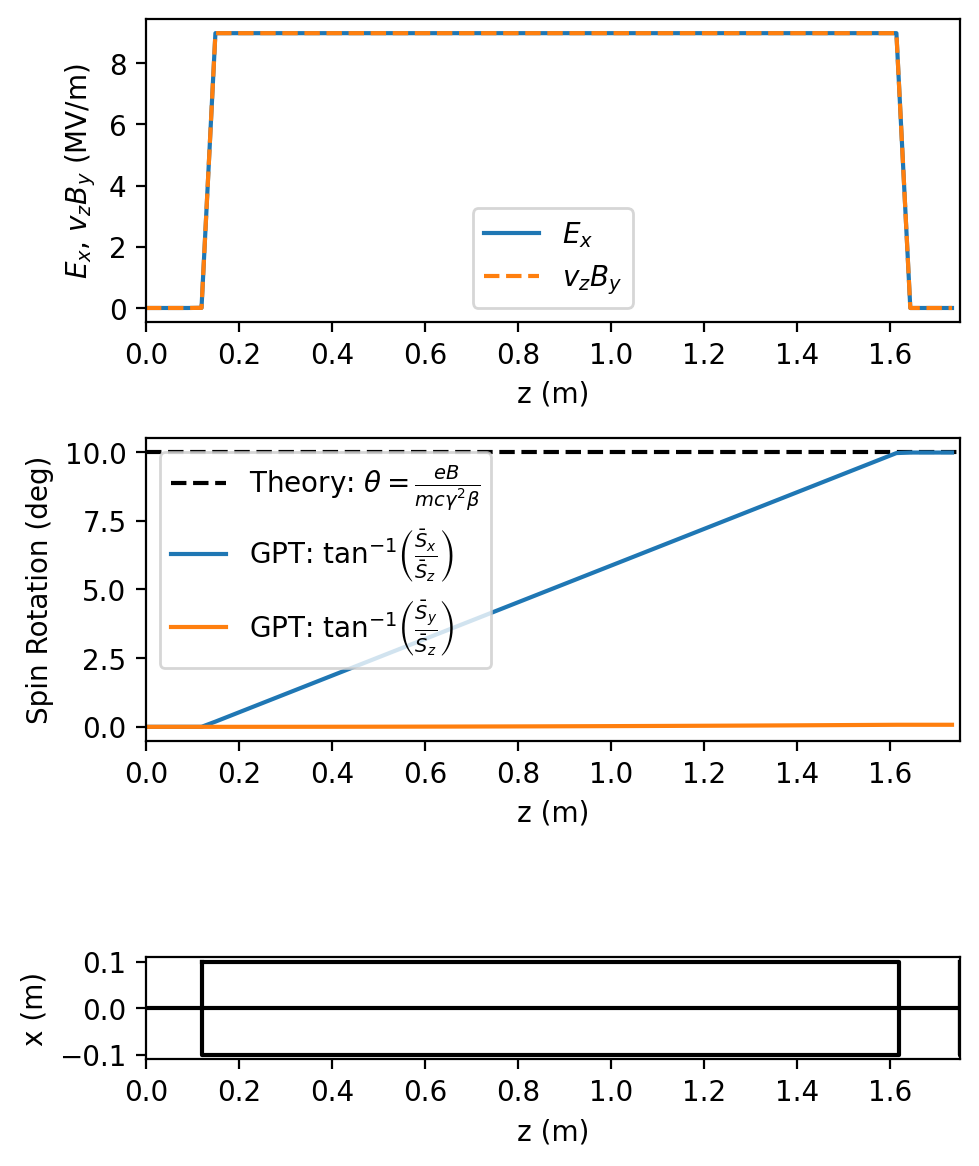

In [51]:
G = GPT('gpt.wf.temp2.in', 
        spin_tracking=True,
        load_fields=True,
        parse_layout=False)

G.set_variables({'Ntout': 500, 'ZSTOP':1.75, 'tmax': 50e-9})
G.run()

fig, axs = plt.subplots(3, 1, figsize=(5, 6))

axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('mean_Ex')/1e6)
axs[0].plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_By')/1e6, '--')
axs[0].set_xlabel('z (m)') 
axs[0].set_ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

axs[0].legend([r'$E_x$', '$v_zB_y$'])

axs[1].plot([0, 4.5], [10, 10], '--k')

thetax = np.atan2(G.tout_stat('mean_sx'), G.tout_stat('mean_sz'))*180/np.pi
thetay = np.atan2(G.tout_stat('mean_sy'), G.tout_stat('mean_sz'))*180/np.pi           

axs[1].plot(G.tout_stat('mean_z'), thetax - thetax[0])
axs[1].plot(G.tout_stat('mean_z'), thetay - thetay[0])

axs[1].set_xlabel('z (m)')
axs[1].set_ylabel('Spin Rotation (deg)')
axs[1].legend([r'Theory: $\theta = \frac{eB}{mc\gamma^2\beta}$', 
               r'GPT: $\text{tan}^{-1}\left(\frac{\bar{S}_x}{\bar{S}_z}\right)$', 
               r'GPT: $\text{tan}^{-1}\left(\frac{\bar{S}_y}{\bar{S}_z}\right)$'])


lat2.plot_floor(ax=axs[-1])

for ii in range(len(axs)):
    axs[ii].set_xlim([0, 1.75])

plt.tight_layout()

In [49]:
#B3.twiss('y')